In [1]:
import pandas as pd
import LendingClubFunctions as LC
import re
import nltk
from sklearn import tree
import numpy as np
import math
%pylab inline
pylab.rcParams['figure.figsize']=(8.0,6.0)


Populating the interactive namespace from numpy and matplotlib


# Load Data In

In [2]:
#Define data location
file1='./data/LoanStats3a.csv'
file2='./data/LoanStats3b.csv'
file3='./data/LoanStats3c.csv'
file4='./data/LoanStats3d.csv'
files=[file1,file2,file3,file4]

In [3]:
cols=['loan_amnt','funded_amnt','total_pymnt', 'loan_status', 'int_rate', 'term',
      'desc', 'grade', 'annual_inc', 'purpose', 'emp_length', 'earliest_cr_line', 
      'revol_util', 'home_ownership', 'sub_grade', 'addr_state', 'dti', 'revol_bal', 'installment', 'last_pymnt_d', 'issue_d']

In [4]:
#Load data in from files
df1=LC.GetData(cols, files)

/Users/admin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Clean The Data

In [5]:
Trouble=[ 'Charged Off', 'Default', 'Does not meet the credit policy.  Status:Charged Off']
Success=['Fully Paid', 'Does not meet the credit policy.  Status:Fully Paid']
df1=LC.CleanData(df1, Success=Success, Trouble=Trouble)

# Look at Status of Loans and Originations

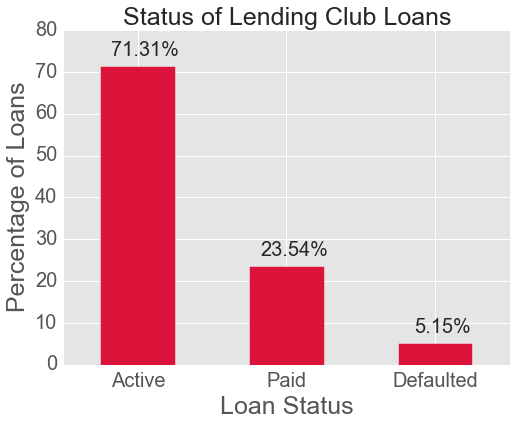

In [6]:
temp=100.*df1.groupby('loan_status').count().int_rate.sort_values(ascending=False)*1.0/df1.count().int_rate
temp.index=['Active', 'Paid', 'Defaulted']
ax4=(temp).plot(kind='bar',rot=0, color='crimson')
ax4.set_xlabel('Loan Status')
ax4.set_ylabel('Percentage of Loans')
ax4.set_title('Status of Lending Club Loans')
ax4.xaxis.label.set_fontsize(25)
ax4.yaxis.label.set_fontsize(25)
ax4.title.set_fontsize(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

rects = ax4.patches

# Now make some labels
labels = [("%.2f" % i) +"%" for i in temp]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax4.text(rect.get_x() + rect.get_width()/2+.05, height + 1.5, label, ha='center', va='bottom', fontsize=20)
savefig('status.jpg', bbox_inches='tight')

In [7]:
df1['year']=df1.issue_d.apply(lambda x: x.year)
temp=df1.groupby('year').sum().funded_amnt
temp.index=[str(int(i)) for i in temp.index]

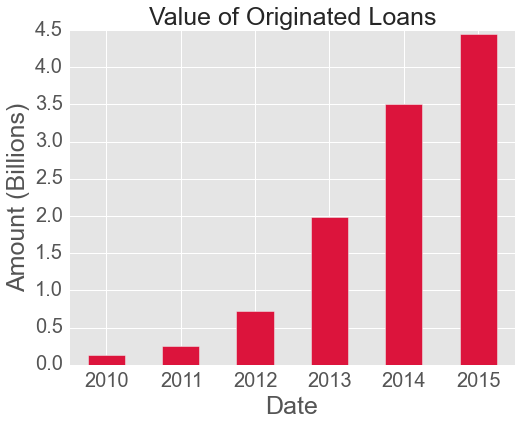

In [8]:
ax4=(temp[[str(i) for i in range(2010, 2016)]]/10**9).plot(kind='bar', rot=0, color='crimson')
#(df1.groupby('issue_d').sum().funded_amnt.cumsum()/10**9).plot(kind='line', ax=ax4)
ax4.set_xlabel('Date')
ax4.set_ylabel('Amount (Billions)')
ax4.set_title('Value of Originated Loans')
ax4.xaxis.label.set_fontsize(25)
ax4.yaxis.label.set_fontsize(25)
ax4.title.set_fontsize(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
savefig('valueofloans.jpg', bbox_inches='tight')

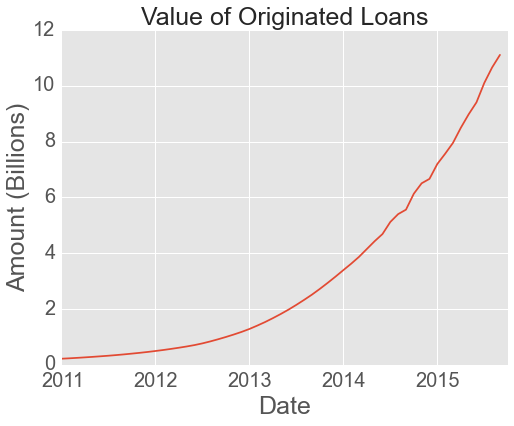

In [9]:
ax4=(df1.groupby('issue_d').sum().funded_amnt.cumsum()/10**9).plot(kind='line')
ax4.set_xlabel('Date')
ax4.set_ylabel('Amount (Billions)')
ax4.set_title('Value of Originated Loans')
ax4.xaxis.label.set_fontsize(25)
ax4.yaxis.label.set_fontsize(25)
ax4.title.set_fontsize(25)
plt.xlim(['2011-01-01','2015-10-01' ])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
savefig('valueofloans.jpg', bbox_inches='tight')

# Start With Visualization of Investor's Lost Money

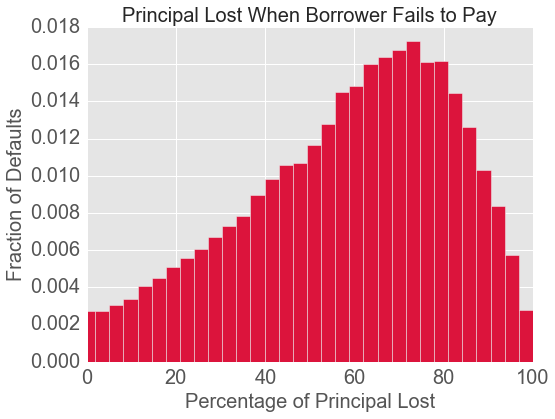

In [10]:
#Lost Principal in Defaults
ax1=plt.hist(-(df1[(df1['loan_status']==bin(0)) & (df1.funded_amnt>1)].PerLoss).as_matrix()*100, bins=50,  color='crimson', label='Charged off/in default', stacked=True, histtype='barstacked', alpha=1, normed=1)
plt.xlabel('Percentage of Principal Lost', fontsize=20)
plt.ylabel('Fraction of Defaults', fontsize=20)
plt.title('Principal Lost When Borrower Fails to Pay', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,100])
ax4.xaxis.label.set_fontsize(25)
ax4.yaxis.label.set_fontsize(25)
ax4.title.set_fontsize(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
savefig('lost_prin.jpg', bbox_inches='tight')

(0, 100)

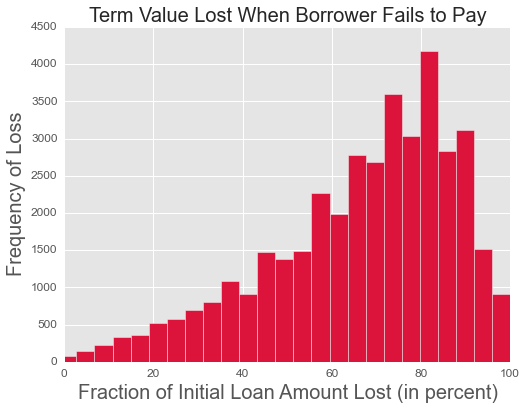

In [11]:
#Lost Term Value in Defaults
ax1=plt.hist(-(df1[(df1['loan_status']==bin(0)) & (df1.funded_amnt>1)].PerLossTerm).as_matrix()*100, bins=30,  color='crimson', label='Charged off/in default', stacked=True, histtype='barstacked', alpha=1)
plt.xlabel('Fraction of Initial Loan Amount Lost (in percent)', fontsize=20)
plt.ylabel('Frequency of Loss', fontsize=20)
plt.title('Term Value Lost When Borrower Fails to Pay', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,100])


# Visualization By State

In [12]:
grouped=df1.groupby(['addr_state', 'loan_status'])
bystate=grouped.count().loan_amnt.dropna()
bystateIntRate=df1.groupby(['addr_state']).mean().int_rate
bystateSTD=df1.groupby(['addr_state']).std().int_rate
StateData=pd.DataFrame([bystate[state].as_matrix() for state in df1.addr_state.dropna().unique()], index=df1.addr_state.dropna().unique(), columns=['Active', 'Defaulted', 'Paid'])
StateData['State']=StateData.index
StateData['Total']=StateData['Defaulted']+StateData['Paid']+StateData['Active']
StateData['IntRate']=100*bystateIntRate
StateData['DefaultRate']=100*StateData['Defaulted']/StateData['Total']
StateData['Country']='USA'
StateData=StateData[StateData.Total>1000]
StateData['STDERR']=100.*bystateSTD/np.sqrt(StateData['Total'])
StateData.to_csv('./Defaults_by_State.csv', columns=['State', 'Country', 'DefaultRate', 'Total', 'IntRate', 'STDERR'], index=False)

In [13]:
#The above data was used to create the cartodb plot on the web app

# Plot Default Rates as a Function of Different Features

In [14]:
class PlaceLoanAmnt:
    def __init__(self):
        self.bins=None
        self.groupnames=None
        self.DFrates=None
    
    def GetInfo(self, value):
        for i in range(len(self.bins)-1):
            if self.bins[i]<=value<self.bins[i+1]:
                return self.groupnames[i]
        if value<self.bins[0]:
            return self.groupnames[0]
        else:
            return self.groupnames[-1]

def ExploreDefaultRate(df1, attribute, Nbins=10, filename='nothing', MakeDill=False, xlabel=None, xmult=1, SaveFig=True):
    
    if not xlabel:
        xlabel=attribute
    
    dx=1./Nbins
    bins=df1[attribute].quantile(np.arange(0,1, dx))
    BINS=pd.Series(df1[attribute].quantile(np.arange(0,1-dx, dx)).as_matrix(), index=range(0,Nbins-1))
    group_names=range(0,len(bins)-1)
    categories = pd.cut(df1[attribute], bins, labels=group_names)
    try:
         df1.drop('LACat', axis=1, inplace=True)
    except:
        pass
   
    df1['LACat']=categories
    byLACat=df1.dropna().groupby(['LACat', 'loan_status'])['LACat'].count()
    LoanCatdf=pd.DataFrame([byLACat[Cat] for Cat in df1.LACat.dropna().unique()], index=df1.LACat.dropna().unique())
    LoanCatdf.columns=['Active', 'Defaulted', 'Paid']
    LoanCatdf['Total']=LoanCatdf['Active']+LoanCatdf['Defaulted']+LoanCatdf['Paid']
    LoanCatdf['DefaultRate']=100.*LoanCatdf['Defaulted']/LoanCatdf['Total']
    AboutLoanAmount=PlaceLoanAmnt()
    AboutLoanAmount.bins=bins.as_matrix()
    AboutLoanAmount.groupnames=group_names
    AboutLoanAmount.DFrates=LoanCatdf
    if MakeDill:
        file1=open(filename+".txt", 'w')
        A=dill.dumps(AboutLoanAmount)
        print >> file1, A
        file1.close()

    
    LoanCatdf=LoanCatdf.sort_index()
    LoanCatdf['bin']=BINS
    ERRR=np.sqrt(LoanCatdf.DefaultRate*(100-LoanCatdf.DefaultRate)/LoanCatdf['Total'])
    plt.errorbar(xmult*LoanCatdf.bin, LoanCatdf.DefaultRate,  yerr=ERRR)
    plt.xlabel(xlabel,fontsize=25)
    plt.ylabel("Default Rate",fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    if SaveFig:
        plt.savefig(filename+".png")
    
    return

/Users/admin/anaconda/lib/python2.7/site-packages/pandas/core/index.py:4394: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_value(s, k)
/Users/admin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


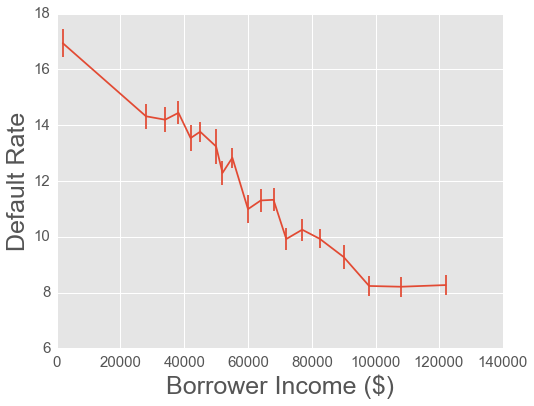

In [15]:
ExploreDefaultRate(df1, 'annual_inc', Nbins=20, filename='BorrowerIncome', MakeDill=False, xlabel='Borrower Income ($)')
savefig('defaultRate_income.png')

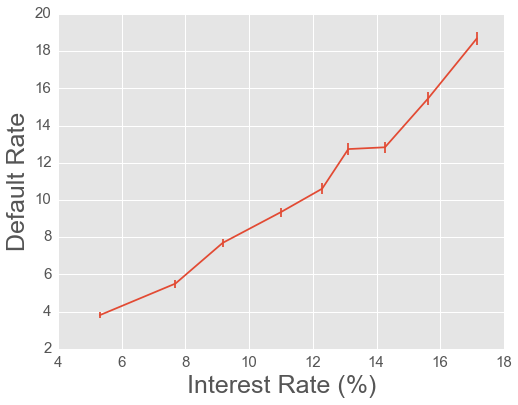

In [16]:
ExploreDefaultRate(df1, 'int_rate', Nbins=10, filename='InterestRate', MakeDill=False, xlabel='Interest Rate (%)', xmult=100)
savefig('defaultRate_int.png')

In [17]:
df1.columns

Index([u'loan_amnt', u'funded_amnt', u'term', u'int_rate', u'installment',
       u'grade', u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc',
       u'issue_d', u'loan_status', u'desc', u'purpose', u'addr_state', u'dti',
       u'earliest_cr_line', u'revol_bal', u'revol_util', u'total_pymnt',
       u'last_pymnt_d', u'OldHome', u'OldStatus', u'purposedummy',
       u'addr_statedummy', u'sub_gradedummy', u'Fraction_Of_Total', u'IntCat',
       u'ROI', u'ROIAnnualized', u'PerLoss', u'PerLossTerm', u'year',
       u'LACat'],
      dtype='object')

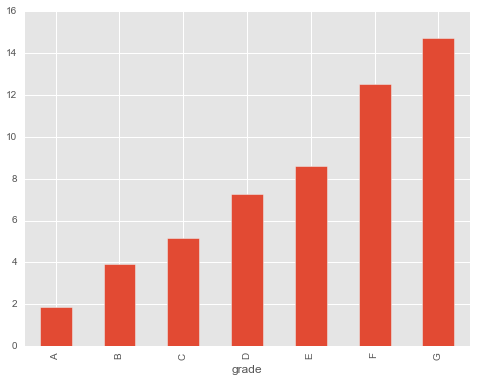

In [18]:
(100*df1[df1.loan_status=='0b0'].groupby(['grade']).count().term*1.0/df1.groupby(['grade']).count().term).plot(kind='bar')

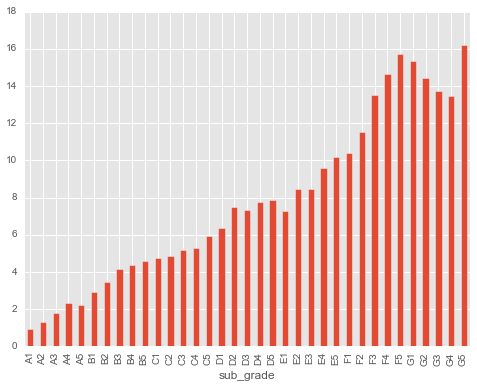

In [19]:
(100*df1[df1.loan_status=='0b0'].groupby(['sub_grade']).count().term*1.0/df1.groupby(['sub_grade']).count().term).plot(kind='bar')

# Interest Rate Categories

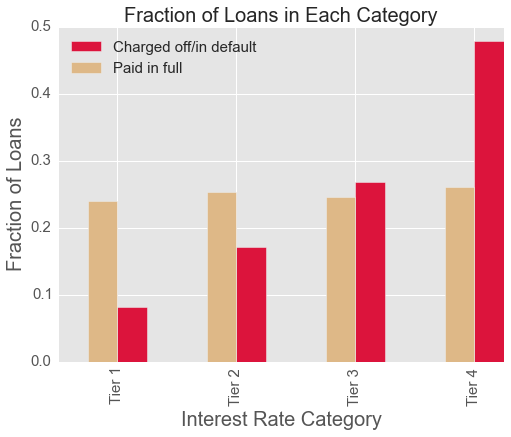

In [20]:
grouped=df1.groupby(['loan_status', 'IntCat'])
PaidRates=(grouped.count()['int_rate'])['0b1']/((grouped.count()['int_rate'])['0b1'].sum())
LostRates=(grouped.count()['int_rate'])['0b0']/((grouped.count()['int_rate'])['0b0'].sum())

ax4=LostRates.plot(kind='bar', color='crimson', position=0, width=.25, label='Charged off/in default', fontsize=15)
ax5=PaidRates.plot(kind='bar', color='burlywood', position=1, width=.25, label= 'Paid in full', fontsize=15)
ax4.set_xlabel('Interest Rate Category')
ax4.set_ylabel('Fraction of Loans')
ax4.set_title('Fraction of Loans in Each Category')
plt.legend( loc='best', prop={'size':15})
ax4.xaxis.label.set_fontsize(20)
ax4.yaxis.label.set_fontsize(20)
ax4.title.set_fontsize(20)

# Term Value of Loans

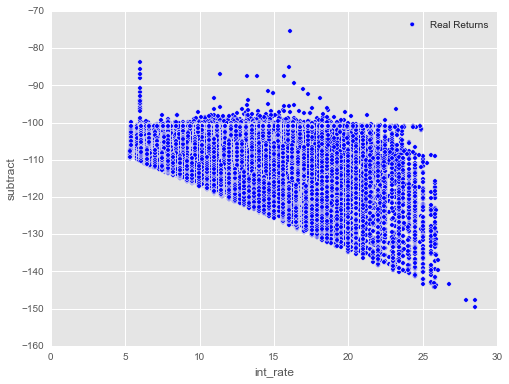

In [21]:
temp=df1[(df1.loan_status!=bin(0)) & (df1.loan_status!=2)& (df1.term==36)].copy()
temp[['int_rate','ROI']]=100.*temp[['int_rate','ROI']]
x=temp.int_rate/100.
temp['subtract']=temp.ROI-300*x*(1+x/12.)**36/((1+x/12.)**36-1)-1
ax=temp.plot(x='int_rate', y='subtract', kind='scatter', color='blue', label='Real Returns')



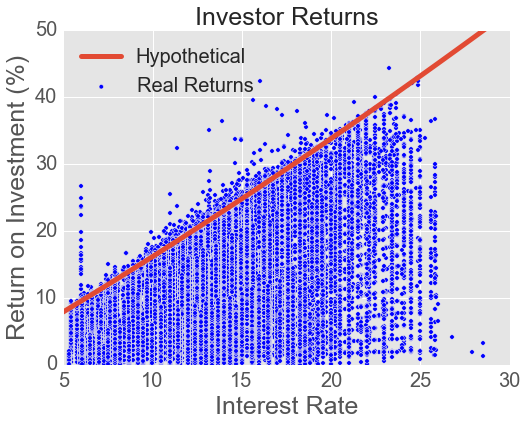

In [22]:
#Plot of the return of investment on all completed loans
temp=df1[(df1.loan_status!=bin(0)) & (df1.loan_status!=2)& (df1.term==36)].copy()
temp[['int_rate','ROI']]=100.*temp[['int_rate','ROI']]
ax=temp.plot(x='int_rate', y='ROI', kind='scatter', color='blue', xlim=(5,30), ylim=(0, 50), label='Real Returns')
#df1[(df1.loan_status!=bin(1)) & (df1.loan_status!=2)].plot(x='int_rate', y='ROI', kind='scatter', ax=ax, color='red', alpha=.4, label='Defaults')
ax.legend(loc='upper left', fontsize=15)
x=np.arange(0, .3, .01)
y=3*x*(1+x/12.)**36/((1+x/12.)**36-1)-1
plt.plot(100*x,100*y, linewidth=5, label='Hypothetical')
ax.legend(loc='upper left', fontsize=20)
ax.set_xlabel('Interest Rate', fontsize=25)
ax.set_ylabel('Return on Investment (%)', fontsize=25)
ax.xaxis.label.set_fontsize(25)
ax.yaxis.label.set_fontsize(25)
ax.set_title('Investor Returns', fontsize=20)
ax.title.set_fontsize(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
savefig('ROI.jpg', bbox_inches='tight')
#ax.set_yticks({'fontsize':12})

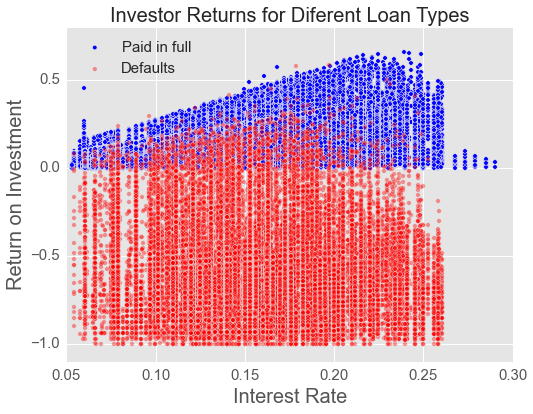

In [23]:
#Plot of the return of investment on all completed loans
ax=df1[(df1.loan_status!=bin(0)) & (df1.loan_status!=2)].plot(x='int_rate', y='ROI', kind='scatter', color='blue', xlim=(0.05,0.3), ylim=(-1.1, .8), label='Paid in full')
df1[(df1.loan_status!=bin(1)) & (df1.loan_status!=2)].plot(x='int_rate', y='ROI', kind='scatter', ax=ax, color='red', alpha=.4, label='Defaults')
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel('Interest Rate', fontsize=20)
ax.set_ylabel('Return on Investment', fontsize=20)
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.set_title('Investor Returns for Diferent Loan Types', fontsize=20)
ax.title.set_fontsize(20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
savefig('ROI.jpg', bbox_inches='tight')
#ax.set_yticks({'fontsize':12})

/Users/admin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


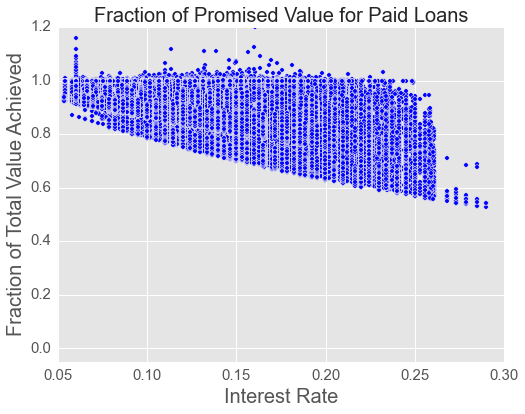

In [24]:
#Plot of how much of the naive term value loans that are paid off actually achieve
df1['Fraction_Of_Total']=df1.total_pymnt/(df1.installment*df1.term)
ax=df1[(df1.loan_status!=bin(0)) & (df1.loan_status!=2)].plot(x='int_rate', y='Fraction_Of_Total', kind='scatter', color='blue', xlim=(0.05,0.3), ylim=(-.05, 1.2))
ax.legend(loc='upper left')
ax.set_xlabel('Interest Rate', fontsize=20)
ax.set_ylabel('Fraction of Total Value Achieved', fontsize=20)
ax.set_title('Fraction of Promised Value for Paid Loans', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
savefig('frac.jpg', bbox_inches='tight')

In [25]:
#Repayment term of paid off loans
def GetNano(x):
    return x.value

df3=LC.GetData(['last_pymnt_d', 'issue_d','term', 'loan_status'], files)

df1['Payment_Length']=12.*(pd.to_datetime(df3.last_pymnt_d).apply(GetNano)-pd.to_datetime(df3.issue_d).apply(GetNano))/(10**9*60.*60.*24.*365.)
payment_time=df1[df1.loan_status==bin(1)][['loan_status','Payment_Length', 'term', 'ROIAnnualized','int_rate', 'grade']].copy()


In [26]:
Early=df1[df1.Payment_Length<12]

In [27]:
df2['Total']=df1.funded_amnt

NameError: name 'df2' is not defined

In [ ]:
df2['term']=df1.term
df2['installment']=df1.installment
df2['grade']=df1.grade
df2['status']=df1.loan_status

In [ ]:
control=((df2.grade=='E')|(df2.grade=='G')|(df2.grade=='F'))&(df2.status==bin(1))

In [ ]:
control=((df2.grade=='E')|(df2.grade=='G')|(df2.grade=='F'))&(df2.status==bin(1))
(100*(df2[control].total_rec_int/(df2[control].term*df2[control].installment-df2[control].Total))).describe()
intfractemp=(100*(df2[control].total_rec_int/(df2[control].term*df2[control].installment-df2[control].Total)))
intfractemp=intfractemp[(intfractemp>0)&(intfractemp<100)]
ax=intfractemp.plot(kind='hist', bins=20, color='crimson')
ax.set_xlabel('Percentage of Promised Interest', fontsize=25)
ax.set_ylabel('Number of Loans', fontsize=25)
ax.set_title('Interest Payments Received')
ax.title.set_fontsize(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
savefig('highint_interest.jpg', bbox_inches='tight')

In [ ]:
control=(df2.status==bin(1))
(100*(df2[control].total_rec_int/(df2[control].term*df2[control].installment-df2[control].Total))).describe()
intfractemp=(100*(df2[control].total_rec_int/(df2[control].term*df2[control].installment-df2[control].Total)))
intfractemp=intfractemp[(intfractemp>0)&(intfractemp<100)]
ax=intfractemp.plot(kind='hist', bins=20, color='crimson')
ax.set_xlabel('Percentage of Promised Interest', fontsize=25)
ax.set_ylabel('Number of Loans', fontsize=25)
ax.set_title('Interest Payments Received')
ax.title.set_fontsize(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
savefig('interest.jpg', bbox_inches='tight')

In [ ]:
#Over all loans
payment_time['Difference']=(payment_time.Payment_Length)/payment_time.term
ax=payment_time.Difference.hist(bins=30, color='crimson')
ax.set_xlabel('Payback time as a fraction of loan term', fontsize=25)
ax.set_ylabel('Number of Loans', fontsize=25)
ax.set_title('Payback Time of P2P loans')
ax.title.set_fontsize(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, 1.03])
savefig('payback_all.jpg', bbox_inches='tight')

In [ ]:
payment_time[(payment_time.grade=='E')|(payment_time.grade=='G')|(payment_time.grade=='F')].Difference.describe()

In [ ]:
#Over high interest loans
ax=payment_time[(payment_time.grade=='E')|(payment_time.grade=='G')|(payment_time.grade=='F')].Difference.hist(bins=30, color='crimson')
ax.set_ylabel('Number of Loans', fontsize=25)
ax.set_title('Payback Time of High Interest Loans')
ax.title.set_fontsize(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, 1.03])
savefig('payback_high_interest.jpg', bbox_inches='tight')

# Bokeh Plots for Web App

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.embed import components
from bokeh.plotting import *
import dill
output_notebook()

In [ ]:

Names=['Loan Amount', 'Borrower Income', 'Loan Interest Rate', 'Borrower Credit Utilization']
Labels=['Loan Amount (1000\'s of $)', 'Borrower Income  (1000\'s of $)', 'Loan Interest Rate (%)', 'Borrower Credit Utilization (%)']
Ops=[1.0/1000, 1.0/1000, 100, 100]
Feats=['loan_amnt','annual_inc','int_rate','revol_util' ]
Tiers=['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4']
Limits=[35000, 200000, 1, 1]

In [ ]:
for Tier in Tiers:
    for f,n,l,op, lim in zip(Feats, Names, Labels, Ops, Limits):
        p1 = figure(title="                "+Tier+" by "+n,
       background_fill="#E8DDCB", x_axis_label=l, y_axis_label='Fraction of Borrowers', width=800, height=400)
        hist1, edges1 = np.histogram((op*df1[(df1.loan_status==bin(0))&(df1.IntCat==Tier)&(df1[f]<lim)][f]).dropna().as_matrix(), density=True, bins=20)
        hist2, edges2 = np.histogram((op*df1[(df1.loan_status==bin(1))&(df1.IntCat==Tier)&(df1[f]<lim)][f]).dropna().as_matrix(), density=True, bins=20)
        p1.min_border_left=150
        p1.quad(top=hist2, bottom=0, left=edges2[:-1], right=edges2[1:], fill_color="burlywood", line_color="#033649", legend='Paid')
        p1.quad(top=hist1, bottom=0, left=edges1[:-1], right=edges1[1:], fill_color="crimson", line_color="#033649", alpha=.5, legend='Defaulted')
        show(p1)
        f1=open('./Bokehs/'+Tier+f, 'w')
        print >> f1, dill.dumps(p1)
        f1.close()

